## fbprophet library walkthrough
This notebook is to show how to use facebook open source **Prophet** library.  

Prophet is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.  

A few features I'm going to try here:  
1. Create prophet dataset: special naming convention, time column: 'ds', target column: 'y'  
2. Build prophet forecast model  
3. Change the forecast period to monthly, on prophet, the default freq is daily. However user can tweak it to be higher or lower freqeuncy  
4. Customize the plot to display holdout set
5. Add external variables to increase model accuarcy


### Dataset explain

This dataset from MundiIndex, which is 15 years of monthly price for a few raw materials.  
Want to see how propane's price changed and crude oil's influnce on it.


In [106]:
from fbprophet import Prophet
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
# use the quick accuarcy measure of mape 
def mape(actual, pred):
    mape = np.mean(abs((actual-pred/actual)))*100
    print('model accuarcy is %.2f'% mape, "%")
    return mape

#### Prepare input data
The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column must contain a date or datetime (either is fine). The y column must be numeric, and represents the measurement we wish to forecast.

In [44]:
# Python
df = pd.read_csv('./RawMaterialPrice.csv')
df['Day'] = '01'

# Convert to time stamp
df['ds'] =pd.to_datetime(df[['Year', 'Month','Day']])

# Rename target to be 'y'
df.rename(columns={'Propane':'y'}, inplace=True)
# Rearrange column orders
df = df[['ds', 'Crude', 'y']]
df.head()

,ds,Crude,y
0,2003-03-01,30.36,0.62
1,2003-04-01,25.56,0.50
2,2003-05-01,26.06,0.54
3,2003-06-01,27.92,0.56
4,2003-07-01,28.59,0.53


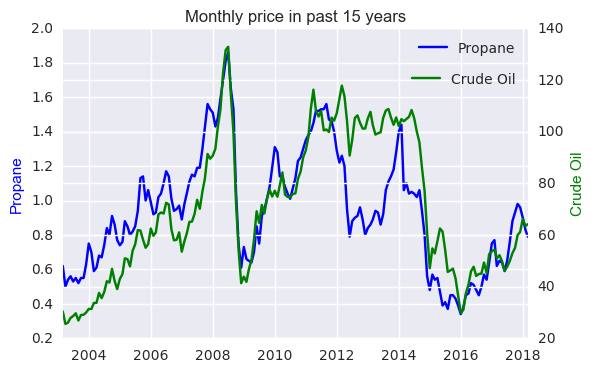

In [183]:
fig, ax1 = plt.subplots()
ax1.plot(df['ds'],df['y'],'b',label = 'Propane')
ax1.set_ylabel('Propane', color='b')
plt.legend(bbox_to_anchor=(1, 1))
ax2 = ax1.twinx()
ax2.plot(df['ds'],df['Crude'],'g',label = 'Crude Oil')
ax2.set_ylabel('Crude Oil', color='g')
plt.title('Monthly price in past 15 years')
plt.legend(bbox_to_anchor=(1, 0.9))

In [81]:
train_idx = 169
test_idx = 181

#### Instantiating a new Prophet object. 
Any settings to the forecasting procedure are passed into the constructor. Then you call its fit method and pass in the historical dataframe. Fitting should take 1-5 seconds.

In [154]:
# Python
m = Prophet()
m.fit(df[0:train_idx])

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [155]:
future = m.make_future_dataframe(periods=12, freq = 'M')
future.tail()

,ds
176,2017-10-31
177,2017-11-30
178,2017-12-31
179,2018-01-31
180,2018-02-28


In [156]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2017-10-31,0.469977,0.149140,0.768388
177,2017-11-30,0.448999,0.122061,0.750005
178,2017-12-31,0.437558,0.111996,0.764318
179,2018-01-31,0.430127,0.121386,0.716595
180,2018-02-28,0.370872,0.031481,0.685510


In [157]:
mape(df['y'][176:181],forecast['yhat'][176:181])

model accuarcy is 40.78 %


40.777303407127086

As we see the model is pretty poor and unfortunately prophet doesn't have much room to tune the model, so we can add additional information see if it helps.  

### Add external variables

In [83]:
# Python
m = Prophet()
m = m.add_regressor('Crude')
m.fit(df[0:train_idx])

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [88]:
future = m.make_future_dataframe(periods=12, freq = 'M')
future['Crude'] = df['Crude']

future.tail()

,ds,Crude
176,2017-10-31,59.93
177,2017-11-30,61.19
178,2017-12-31,66.23
179,2018-01-31,63.46
180,2018-02-28,64.17


In [90]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
176,2017-10-31,0.691975,0.523440,0.842683
177,2017-11-30,0.747457,0.597891,0.903421
178,2017-12-31,0.822390,0.669899,0.980789
179,2018-01-31,0.735350,0.587197,0.902900
180,2018-02-28,0.689619,0.530298,0.844552


In [146]:
mape(df['y'][176:181],forecast['yhat'][176:181])

model accuarcy is 12.16 %


12.159359032689595

### Customize the plot to show prediction vs actual on holdout set

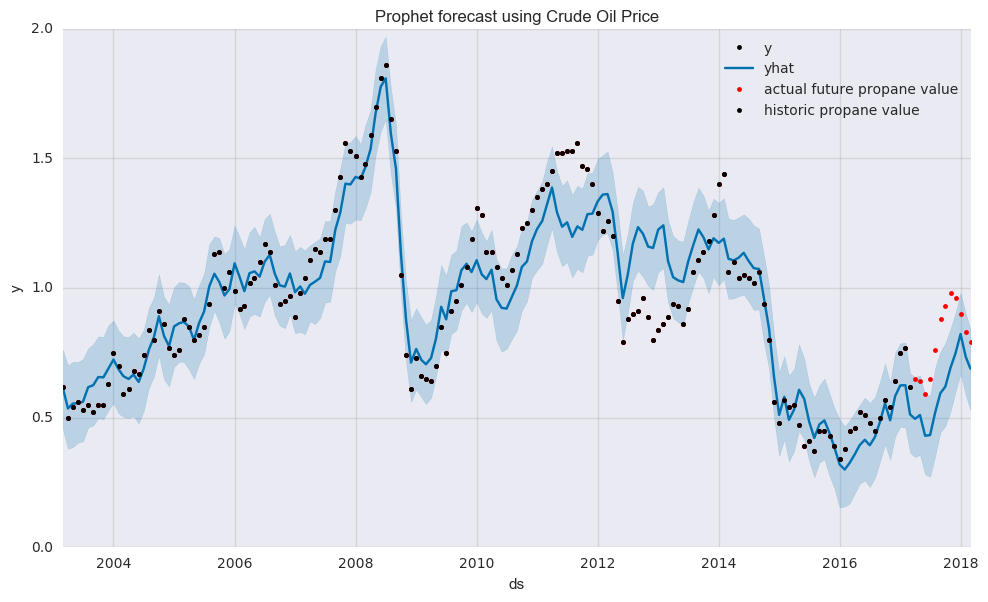

In [153]:
m.plot(forecast)
plt.plot(df['ds'], df['y'],'r.',label ='actual future propane value')
plt.plot(df['ds'][0:train_idx], df['y'][0:train_idx],'k.', label ='historic propane value')
plt.legend()
plt.title('Prophet forecast using Crude Oil Price')


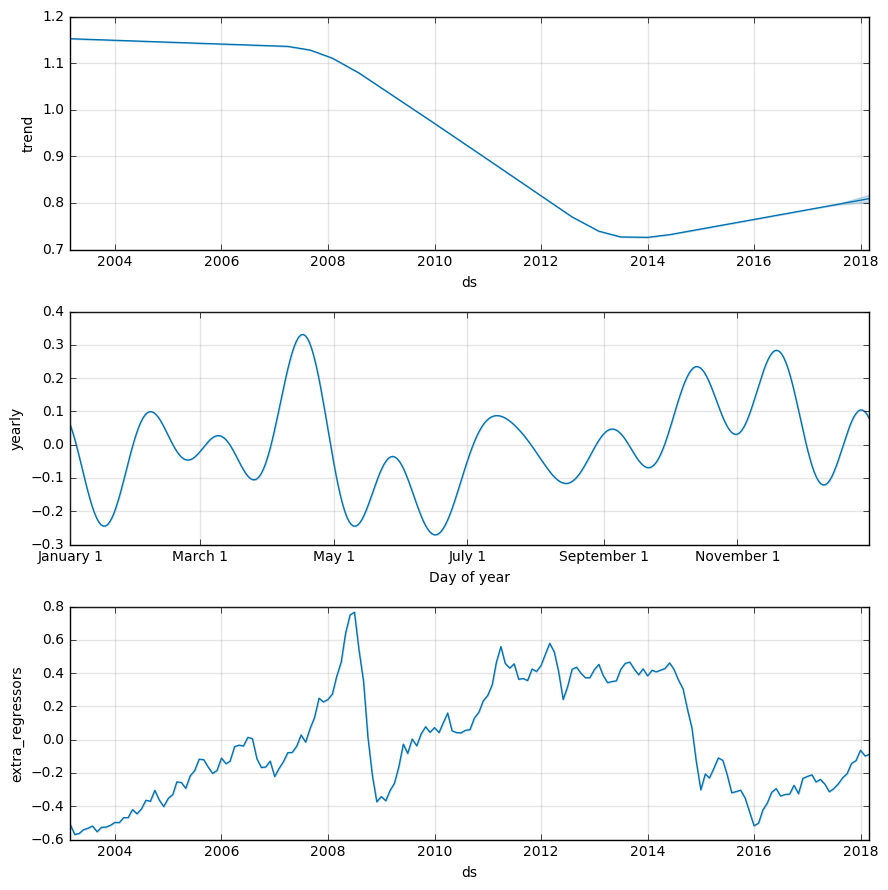

In [94]:
m.plot_components(forecast);

### Summary:

#### Pros:
Prophet is really easy to use. The dataset I choose is not ideal to maximize it's advantages, such as missing value, seasonality, holidays stuff. But I already see it's simplified the stationary test, checking auto correlation kind of thing.  
Model accuracy is also not bad.
If I have a very messy ts data, I would definitely want to try this again.

#### Cons: 
Intepretability: I can't see what's the contribution for crude oil and price sensitivity. Due to the backend prophet model is actually much more complex than a single coefficient. Their paper is also interesting to read(https://peerj.com/preprints/3190/)  